# Feature Engineering

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics

In [2]:
# Read in sumo csv data
sumo_df = pd.read_csv('../data/sumo_df.csv')

## Table of Contents
- [Checking For Duplicate Rikishi](#Checking-For-Duplicate-Rikishi)
- [Nonparticipating Rikishi](#Nonparticipating-Rikishi)
- [Populating Data Manually](#Populating-Data-Manually)
- [Rankings](#Rankings)
- [Grouping Rikishi Ranks](#Grouping-Rikishi-Ranks)
- [Create Age Feature](#Create-Age-Feature)
- [Create Win Ratio Feature](#Create-Win-Ratio-Feature)
- [Create Tenure Feature](#Create-Tenure-Feature)
- [Create Ichimon Feature](#Create-Ichimon-Feature)
- [Remove Features](#Remove-Features)

## Checking For Duplicate Rikishi

#### There should only be one ID per rikishi, but some of them are duplicated.  Check Japan Sumo Association to cros check record data.

In [3]:
sumo_df['sumodb_id'].value_counts()

sumodb_id
12545    2
12105    2
12816    2
8903     2
7497     1
        ..
12514    1
943      1
1460     1
10641    1
12896    1
Name: count, Length: 8938, dtype: int64

In [4]:
sumo_df[sumo_df['sumodb_id'] == 12545]

,id,sumodb_id,nsk_id,ring_name,current_rank,heya,birthday,height,weight,debut,retirement,total_wins,total_losses,total_matches
343,8175,12545,3936,Daishinkai,Jonidan 30 East,Otake,1992-12-24T15:00:00Z,180.0,167.0,201903,NaN,41,65,106
2953,217,12545,3936,Daishinkai,Sandanme 22 West,Otake,2000-04-25T00:00:00Z,174.0,135.0,201903,NaN,103,93,196


In [5]:
# record 2953 is correct for Daishinkai
sumo_df.drop(index = 343, inplace = True)

In [6]:
sumo_df[sumo_df['sumodb_id'] == 12105]

,id,sumodb_id,nsk_id,ring_name,current_rank,heya,birthday,height,weight,debut,retirement,total_wins,total_losses,total_matches
6378,189,12105,0,Oki,Sandanme 66 East,Shikoroyama,1996-06-12T00:00:00Z,182.0,153.0,201307,2024-06-28T00:00:00Z,231,192,423
8932,8934,12105,3496,Oki,Sandanme 36 West,Shikoroyama,1996-06-11T15:00:00Z,186.0,158.8,202407,NaN,0,0,0


In [7]:
# 6378 is the correct record for Oki
sumo_df.drop(index = 8932, inplace = True)

In [8]:
sumo_df[sumo_df['sumodb_id'] == 12816]

,id,sumodb_id,nsk_id,ring_name,current_rank,heya,birthday,height,weight,debut,retirement,total_wins,total_losses,total_matches
8782,8861,12816,4207,Togyokuko,Jonidan 78 West,Tamanoi,2007-08-29T00:00:00Z,172.0,114.0,202305,NaN,22,30,52
8807,8886,12816,4207,Togyokuko,Jonidan 86 East,Tamanoi,2007-08-29T00:00:00Z,172.0,119.3,202311,NaN,0,0,0


In [9]:
# 8782 is the correct record for Togyokuko
sumo_df.drop(index = 8807, inplace = True)

In [10]:
sumo_df[sumo_df['sumodb_id'] == 8903]

,id,sumodb_id,nsk_id,ring_name,current_rank,heya,birthday,height,weight,debut,retirement,total_wins,total_losses,total_matches
8533,246,8903,0,Keitenkai,Sandanme 43 West,Onomatsu,1990-03-10T00:00:00Z,175.5,113.0,200801,2024-03-05T00:00:00Z,336,252,588
8902,8904,8903,3059,Keitenkai,Sandanme 43 West,Onomatsu,1990-03-09T15:00:00Z,175.0,112.5,202403,NaN,0,0,0


In [11]:
# 8533 is the correct record for Keitenkai
sumo_df.drop(index = 8902, inplace = True)

In [12]:
# All Rikishi duplicates have been removed
sumo_df['sumodb_id'].value_counts()

sumodb_id
10438    1
5531     1
11780    1
7497     1
7122     1
        ..
943      1
1460     1
10641    1
2415     1
12896    1
Name: count, Length: 8938, dtype: int64

## Nonparticipating Rikishi

#### The following rikishi have no match record. Either they are brand new in the Japan Sumo Association or they retired before participating in any basho.  Unable to specifically confirm reasons for the latter, but suspect injury, personal reasons, or inaccurate data (Nakanotate was active, but no specific match data in this set).

In [13]:
#508 total records have no match data.  The model is meant to predict how successful a rikishi is basedo on wins, so these rows will be dropped.
sumo_df[(sumo_df['total_wins'] == 0) & (sumo_df['total_losses'] == 0)]


,id,sumodb_id,nsk_id,ring_name,current_rank,heya,birthday,height,weight,debut,retirement,total_wins,total_losses,total_matches
17,7297,7962,0,Hoshisato,NaN,Michinoku,1961-10-23T00:00:00Z,172.5,78.0,197909,1979-11-01T00:00:00Z,0,0,0
24,8831,10516,0,Asakaze,NaN,-,0001-01-01T00:00:00Z,NaN,NaN,195907,1959-09-01T00:00:00Z,0,0,0
29,7944,8926,0,Kakuta,NaN,Oyama,1954-08-27T00:00:00Z,176.0,84.0,197001,1970-03-01T00:00:00Z,0,0,0
35,7715,10474,0,Nakanotate,NaN,-,0001-01-01T00:00:00Z,NaN,NaN,195403,1958-03-01T00:00:00Z,0,0,0
64,4643,7161,0,Takeuchi Yuki,NaN,Shikoroyama,1990-07-21T00:00:00Z,170.0,114.0,200703,2007-05-01T00:00:00Z,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8757,7898,9012,0,Mikami,NaN,-,0001-01-01T00:00:00Z,NaN,NaN,197111,1972-03-01T00:00:00Z,0,0,0
8786,8865,12820,4211,Sogo,Jonokuchi 16 West,Ajigawa,2006-07-26T00:00:00Z,181.0,78.0,202305,2023-05-31T00:00:00Z,0,0,0
8852,7344,8195,0,Sato,NaN,-,0001-01-01T00:00:00Z,NaN,NaN,197611,1977-01-01T00:00:00Z,0,0,0
8940,8942,12894,4285,Ishizaki,Makushita 60 East,Takasago,2000-08-08T15:00:00Z,172.0,117.0,202407,NaN,0,0,0


In [14]:
sumo_df = sumo_df.drop(sumo_df[(sumo_df['total_wins'] == 0) & (sumo_df['total_losses'] == 0)].index)

## Populating Data Manually

In [15]:
# One record is missing a birthday and heya, which is November 25th, 2005 and Ajigawa respectively.  This record was
# different than others as all missing values were NaN instead of a default data for unknown birthdays and '-' for 
# unknown heya.  Easy to look up and correct using the sumodb website.
sumo_df[sumo_df['birthday'].isnull()]

,id,sumodb_id,nsk_id,ring_name,current_rank,heya,birthday,height,weight,debut,retirement,total_wins,total_losses,total_matches
8810,8889,12844,4235,Anhibiki,Sandanme 62 East,NaN,NaN,NaN,NaN,202401,NaN,21,7,28


In [16]:
sumo_df.loc[8810, 'birthday'] = '2005-11-25T00:00:00Z' # Keeping it the same format as other entries, but expect to change this for all later.
sumo_df.loc[8810, 'heya'] ='Ajigawa'

In [17]:
sumo_df.loc[8810]

id                               8889
sumodb_id                       12844
nsk_id                           4235
ring_name                    Anhibiki
current_rank         Sandanme 62 East
heya                          Ajigawa
birthday         2005-11-25T00:00:00Z
height                            NaN
weight                            NaN
debut                          202401
retirement                        NaN
total_wins                         21
total_losses                        7
total_matches                      28
Name: 8810, dtype: object

## Rankings

### This was a large undertaking as many of the rankings were incorrect.  Many retired rikishi still had their old ranks.  This would be the most challenging data to maintain since all rankings for most rikishi change every other month. This project would benefit from automating the process of verifying and updating rankings.

#### There are ten ranks total. There are fixed number of rikishi allowed above rank Sandame.  This includes:

##### Banzuke-gai: No limit - Rikishi who haven't shown up for scheduled jonokuchi matches and dropped from rankings.  Have not officially retired.
##### Jonokuchi: ~80
##### Jonidan: ~260
##### Sandame: ~200
##### Makushita: 120
##### Juryo: 28
##### Maegashira: 32
##### Komusubi: At least two
##### Sekiwake: At least two
##### Ozeki: At least two
##### Yokozuna: Top position - No limit - 73 total rikishi have reached this rank in history of sumo.

#### Each ranking has a numerical sub-rank along with East or West.  East is considered higher in rank.  Jonokuchi 7 East is higher rank than Jonokuchi 7 West, but both are higher ranked than Jonokuchi 8 East.  Any Jonidan is ranked higher than all Jonokuchi.

#### There shouldn't be more than one entry for each full ranking (except for Banzuke-gai but the dataset has up to four entries for some of the ranks. Ranks change every other month after a tournament, so this information changes frequently, esepecially within lower ranks. This feature will not be used for modeling, but may be interesting to visualize the higher ranks.

### Resarching current rikishi rankings to make any corrections to duplicated ranks.

In [18]:
# Showing which ranks are dupklicated
sumo_df['current_rank'].value_counts().head(55)

current_rank
Banzuke-gai          9
Jonokuchi 2 West     4
Jonidan 24 West      3
Jonidan 45 East      3
Jonokuchi 7 West     3
Jonokuchi 14 East    3
Jonidan 97 East      3
Jonidan 87 East      2
Sandanme 85 West     2
Makushita 13 East    2
Sandanme 72 West     2
Makushita 51 West    2
Jonidan 80 East      2
Jonidan 51 East      2
Jonidan 68 East      2
Sandanme 6 West      2
Sandanme 9 East      2
Jonidan 87 West      2
Jonokuchi 16 West    2
Makushita 15 East    2
Sandanme 35 East     2
Jonidan 64 East      2
Sandanme 4 West      2
Jonokuchi 12 West    2
Jonidan 49 East      2
Sandanme 50 West     2
Jonidan 61 West      2
Sandanme 16 West     2
Makushita 36 West    2
Makushita 35 East    2
Sandanme 78 West     2
Jonidan 62 West      2
Sandanme 43 West     2
Sandanme 75 East     2
Sandanme 80 West     2
Sandanme 22 West     2
Sandanme 40 East     2
Makushita 6 West     2
Makushita 5 West     2
Sandanme 59 East     2
Jonokuchi 12 East    2
Sandanme 73 West     2
Jonidan 73 West      

#### All of the following Banzuki-gai have since retired.  Confirmed through the Japan Sumo Association website.  Once a rikishi retires, he cannot return to sumo wrestling.  As a result, some rikishi delay retiring, even though he doesn't compete in basho.

In [19]:
sumo_df[sumo_df['current_rank'] == 'Banzuke-gai']

,id,sumodb_id,nsk_id,ring_name,current_rank,heya,birthday,height,weight,debut,retirement,total_wins,total_losses,total_matches
577,621,12649,0,Hokuozan Kokichi,Banzuke-gai,Naruto,1995-10-18T15:00:00Z,171.4,144.2,202003,NaN,39,17,56
862,627,2929,0,Kagamio Hideoki,Banzuke-gai,Isenoumi,1988-02-09T00:00:00Z,182.0,136.0,200307,NaN,437,408,845
1149,616,12284,0,Izumigawa Ryuchi,Banzuke-gai,Shibatayama,1997-05-12T00:00:00Z,180.0,121.0,201601,NaN,130,129,259
2233,630,5959,0,Ounabara Sho,Banzuke-gai,Shikoroyama,1986-01-19T00:00:00Z,182.0,191.5,200401,NaN,258,269,527
2737,628,12317,0,Kotootomo Shunpei,Banzuke-gai,Sadogatake,1998-02-13T00:00:00Z,186.0,123.0,201603,NaN,89,89,178
3063,605,12307,0,Hokutoshio Ryuki,Banzuke-gai,Hakkaku,2000-06-22T00:00:00Z,173.0,125.0,201603,NaN,110,156,266
4507,625,12668,0,Fujiizumi Aone,Banzuke-gai,Nishikido,2004-04-05T00:00:00Z,184.0,158.0,202101,NaN,18,10,28
4832,619,6502,0,Teraosho Katsuichi,Banzuke-gai,Shikoroyama,1989-04-25T00:00:00Z,180.0,155.0,200503,NaN,328,336,664
8444,620,12474,0,Chikunokura Kyuzo,Banzuke-gai,Musashigawa,2002-06-21T00:00:00Z,174.0,131.0,201803,NaN,81,80,161


In [20]:
# All Banzuki-gai ranks as well as NaNs in current_rank column will be changed to 'Retired'
sumo_df['current_rank'] = sumo_df['current_rank'].replace('Banzuke-gai', 'Retired').fillna('Retired')

#### The Jonokuchi 2 West rank currently belongs to Moriurara.  Kirimaru is retired.  Shosei hasn't competed since September 2023 and is Banzuke-gai.  Hoshi retired in January 2024.

In [21]:
sumo_df[sumo_df['current_rank'] == 'Jonokuchi 2 West']

,id,sumodb_id,nsk_id,ring_name,current_rank,heya,birthday,height,weight,debut,retirement,total_wins,total_losses,total_matches
190,327,6538,2834,Shosei,Jonokuchi 2 West,Sakaigawa,1986-05-27T00:00:00Z,166.0,123.0,200503,NaN,388,371,759
3387,594,2926,2605,Moriurara,Jonokuchi 2 West,Otake,1987-06-16T00:00:00Z,170.0,129.0,200305,NaN,272,592,864
3469,572,1161,0,Kirimaru,Jonokuchi 2 West,Michinoku,1985-04-05T00:00:00Z,173.0,146.0,200103,2024-03-27T00:00:00Z,386,548,934
8789,8868,12823,4214,Hoshi,Jonokuchi 2 West,Asahiyama,2004-11-03T00:00:00Z,178.0,125.0,202305,NaN,9,12,21


In [22]:
sumo_df.loc[[3469, 8789], 'current_rank'] ='Retired'
sumo_df.loc[190, 'current_rank'] = 'Banzuke-gai'

#### The Jonokuchi 14 East rank currently belongs to Yonezawaryu.  Mokotofuji retired in May 2024 and Satokaneko retured in September 2023.

In [23]:
sumo_df[sumo_df['current_rank'] == 'Jonokuchi 14 East']

,id,sumodb_id,nsk_id,ring_name,current_rank,heya,birthday,height,weight,debut,retirement,total_wins,total_losses,total_matches
8770,8849,12804,4195,Makotofuji,Jonokuchi 14 East,Isegahama,2007-05-24T00:00:00Z,175.0,144.0,202305,NaN,9,12,21
8793,8872,12827,4218,Satokaneko,Jonokuchi 14 East,Nishiiwa,2008-02-06T00:00:00Z,168.0,65.0,202305,NaN,2,5,7
8933,8935,12888,4278,Yonezawaryu,Jonokuchi 14 East,Sakaigawa,2005-03-27T15:00:00Z,190.0,133.0,202407,NaN,3,4,7


In [24]:
sumo_df.loc[[8770, 8793], 'current_rank'] ='Retired'

#### The Jonokuchi 7 West rank currently belongs to Narita.  Agazumakakura retired in January 2024 and Tsuyasato hasn't competed since November 2023 and is Banzuke-gai,

In [25]:
sumo_df[sumo_df['current_rank'] == 'Jonokuchi 7 West']

,id,sumodb_id,nsk_id,ring_name,current_rank,heya,birthday,height,weight,debut,retirement,total_wins,total_losses,total_matches
4074,545,12620,0,Agazumazakura,Jonokuchi 7 West,Shikihide,2005-03-15T00:00:00Z,167.0,99.0,202003,2024-01-31T00:00:00Z,47,104,151
6645,444,12421,3812,Tsuyasato,Jonokuchi 7 West,Minato,2001-05-25T00:00:00Z,169.0,155.0,201703,NaN,84,112,196
8918,8920,12866,4257,Narita,Jonokuchi 7 West,Takadagawa,2008-12-09T15:00:00Z,174.0,109.0,202405,NaN,5,8,13


In [26]:
sumo_df.loc[4074, 'current_rank'] ='Retired'
sumo_df.loc[6645, 'current_rank'] = 'Banzuke-gai'

#### The Jonidan 24 West rank currently belongs to Shunkaku.  Suonada retired in May 2023 and Baraki retired in May 2024.

In [27]:
sumo_df[sumo_df['current_rank'] == 'Jonidan 24 West']

,id,sumodb_id,nsk_id,ring_name,current_rank,heya,birthday,height,weight,debut,retirement,total_wins,total_losses,total_matches
5948,423,12532,3923,Suonada,Jonidan 24 West,Sakaigawa,2000-12-26T00:00:00Z,182.0,126.0,201901,2023-05-31T00:00:00Z,75,93,168
6071,428,12469,3860,Shunkaku,Jonidan 24 West,Shikoroyama,2002-10-24T00:00:00Z,164.0,86.0,201803,NaN,115,143,258
8650,303,12052,0,Baraki,Jonidan 24 West,Shikihide,1994-05-10T00:00:00Z,164.0,109.7,201301,2024-05-29T00:00:00Z,229,240,469


In [28]:
sumo_df.loc[[5948, 8650], 'current_rank'] ='Retired'

#### The Jonidan 45 East rank currently belongs to Kirinohana.  Hatachijo retired in January 2024 and Mochizuki retired in May 2024.

In [29]:
sumo_df[sumo_df['current_rank'] == 'Jonidan 45 East']

,id,sumodb_id,nsk_id,ring_name,current_rank,heya,birthday,height,weight,debut,retirement,total_wins,total_losses,total_matches
1722,551,2881,0,Hatachijo,Jonidan 45 East,Yamahibiki,1985-03-19T00:00:00Z,183.0,146.3,200303,2024-01-31T00:00:00Z,397,457,854
7213,457,12606,3997,Kirinohana,Jonidan 45 East,Michinoku,2005-01-08T00:00:00Z,176.0,77.0,202003,NaN,70,105,175
7435,247,12344,3735,Mochizuki,Jonidan 45 East,Otake,1996-03-08T00:00:00Z,175.0,100.0,201607,NaN,159,149,308


In [30]:
sumo_df.loc[[1722, 7435], 'current_rank'] ='Retired'

#### The Jonidan 97 East rank currently belongs to Wakayahara.  Miyabi retired in September 2023 and Raikisho Ryudo retired in November 2023.

In [31]:
sumo_df[sumo_df['current_rank'] == 'Juryo 5 East']

,id,sumodb_id,nsk_id,ring_name,current_rank,heya,birthday,height,weight,debut,retirement,total_wins,total_losses,total_matches
2133,54,12575,3969,Tohakuryu,Juryo 5 East,Tamanoi,1993-06-26T15:00:00Z,182.0,132.0,201905,NaN,192,190,382
2816,43,6599,2895,Tochinoshin,Juryo 5 East,Kasugano,1987-10-13T00:00:00Z,192.0,162.0,200603,2023-05-19T00:00:00Z,681,615,1296


In [32]:
sumo_df.loc[[412, 7175], 'current_rank'] ='Retired'

### All Rikishi that do not have an nsk_id mean they are no longer active in sumo wrestling and will assume to be retired.

In [33]:
sumo_df.loc[sumo_df['nsk_id'] == 0, 'current_rank'] = 'Retired'

In [34]:
sumo_df['current_rank'].value_counts().head()

current_rank
Retired              7779
Jonokuchi 16 East       2
Makushita 6 West        2
Jonidan 51 East         2
Jonokuchi 15 West       2
Name: count, dtype: int64

### There are still some ranks that have two entries.  After exploring the dataset, I noticed that rikishi have a retirement date, but still hold a nsk_id. Seems that rank for these retired rikishi when they retired were left in the dataset.  Rank will be set to 'Retired' if the retirement feature isn't null.

In [35]:
#Example - Tochinoshin was at Juryo 5 East when he lost he first six matches of the May 2023 basho and then retired.
sumo_df[sumo_df['current_rank'] == 'Juryo 5 East']

,id,sumodb_id,nsk_id,ring_name,current_rank,heya,birthday,height,weight,debut,retirement,total_wins,total_losses,total_matches
2133,54,12575,3969,Tohakuryu,Juryo 5 East,Tamanoi,1993-06-26T15:00:00Z,182.0,132.0,201905,NaN,192,190,382
2816,43,6599,2895,Tochinoshin,Juryo 5 East,Kasugano,1987-10-13T00:00:00Z,192.0,162.0,200603,2023-05-19T00:00:00Z,681,615,1296


In [36]:
sumo_df.loc[sumo_df['retirement'].notna(), 'current_rank'] = 'Retired'

### Still 24 ranks that have more than 1 rikishi.  Will check the Japan Sump Association and correct the data.  These are all on the lower ranks of the bracket.  Many of these are instances of rikishi retiring, but their old rankings still show up in their data profile.

In [37]:
sumo_df['current_rank'].value_counts().head(27)

current_rank
Retired              7804
Jonidan 62 West         2
Jonokuchi 16 West       2
Makushita 5 West        2
Makushita 49 East       2
Jonidan 37 West         2
Sandanme 50 West        2
Sandanme 78 West        2
Sandanme 16 West        2
Jonidan 59 East         2
Jonokuchi 1 East        2
Jonidan 52 West         2
Jonidan 71 West         2
Sandanme 22 West        2
Jonokuchi 2 East        2
Jonokuchi 13 East       2
Jonokuchi 13 West       2
Makushita 16 West       2
Banzuke-gai             2
Jonidan 73 West         2
Sandanme 72 West        2
Jonokuchi 18 East       2
Makushita 13 East       2
Sandanme 73 West        2
Jonokuchi 12 East       2
Jonidan 80 East         2
Sandanme 44 East        1
Name: count, dtype: int64

In [38]:
sumo_df[sumo_df['current_rank'] == 'Jonidan 62 West']


,id,sumodb_id,nsk_id,ring_name,current_rank,heya,birthday,height,weight,debut,retirement,total_wins,total_losses,total_matches
1255,554,12257,3648,Watatani,Jonidan 62 West,Arashio,1999-07-07T00:00:00Z,175.0,92.0,201505,NaN,159,196,355
6320,526,6020,2703,Denzan,Jonidan 62 West,Otake,1988-06-08T00:00:00Z,174.0,149.0,200403,NaN,388,386,774


In [39]:
sumo_df.loc[6320, 'current_rank'] ='Retired'

In [40]:
sumo_df[sumo_df['current_rank'] == 'Jonokuchi 16 West']

,id,sumodb_id,nsk_id,ring_name,current_rank,heya,birthday,height,weight,debut,retirement,total_wins,total_losses,total_matches
6133,583,12639,4030,Wakakaneko,Jonokuchi 16 West,Nishiiwa,2004-09-15T00:00:00Z,173.0,94.0,202003,NaN,53,41,94
8938,8940,12886,4276,Kikuchi,Jonokuchi 16 West,Futagoyama,2009-02-02T15:00:00Z,175.0,105.0,202407,NaN,2,5,7


In [41]:
sumo_df.loc[6133, 'current_rank'] ='Retired'

In [42]:
sumo_df[sumo_df['current_rank'] == 'Jonidan 59 East']

,id,sumodb_id,nsk_id,ring_name,current_rank,heya,birthday,height,weight,debut,retirement,total_wins,total_losses,total_matches
5331,453,12371,3760,Gokishin,Jonidan 59 East,Shikihide,1992-06-01T00:00:00Z,164.0,160.0,201703,NaN,141,160,301
8797,8876,12831,4222,Itoga,Jonidan 59 East,Sakaigawa,2007-07-02T00:00:00Z,174.0,115.0,202305,NaN,11,10,21


In [43]:
sumo_df.loc[8797, 'current_rank'] ='Retired'

In [44]:
sumo_df[sumo_df['current_rank'] == 'Jonidan 37 West']

,id,sumodb_id,nsk_id,ring_name,current_rank,heya,birthday,height,weight,debut,retirement,total_wins,total_losses,total_matches
3416,560,12583,3974,Sakurai,Jonidan 37 West,Naruto,1997-03-15T00:00:00Z,184.0,122.0,201905,NaN,81,52,133
8772,8851,12806,4197,Miyatani,Jonidan 37 West,Musashigawa,2007-05-07T15:00:00Z,178.0,119.0,202305,NaN,26,30,56


In [45]:
sumo_df.loc[3416, 'current_rank'] ='Retired'

In [46]:
sumo_df[sumo_df['current_rank'] == 'Jonokuchi 13 West']

,id,sumodb_id,nsk_id,ring_name,current_rank,heya,birthday,height,weight,debut,retirement,total_wins,total_losses,total_matches
4849,62,12412,3803,Enho,Jonokuchi 13 West,Miyagino,1995-01-27T15:00:00Z,167.0,100.6,201703,NaN,234,222,456
5261,574,12676,4067,Yoshinofuji,Jonokuchi 13 West,Isegahama,2001-07-20T00:00:00Z,170.0,94.0,202103,NaN,27,48,75


In [47]:
sumo_df.loc[5261, 'current_rank'] ='Retired'

In [48]:
sumo_df[sumo_df['current_rank'] == 'Jonidan 80 East']

,id,sumodb_id,nsk_id,ring_name,current_rank,heya,birthday,height,weight,debut,retirement,total_wins,total_losses,total_matches
6225,459,12735,4126,Noguchi,Jonidan 80 East,Futagoyama,2006-08-09T00:00:00Z,168.0,149.0,202203,NaN,20,22,42
8767,8846,12801,4192,Daishoheki,Jonidan 80 East,Oitekaze,2004-07-19T00:00:00Z,177.0,160.0,202305,NaN,26,30,56


In [49]:
sumo_df.loc[6225, 'current_rank'] ='Retired'

#### This is an unusual one because Daishinkai's current rank is actually Jonidan 30 East and is not retired like the others have been so far.  This database doesn't have anyone in that rank, so I will change Daishinkai's rank to Jonidan 30 East.

In [50]:
sumo_df[sumo_df['current_rank'] == 'Sandanme 22 West']

,id,sumodb_id,nsk_id,ring_name,current_rank,heya,birthday,height,weight,debut,retirement,total_wins,total_losses,total_matches
1987,169,12064,3454,Chiyonokatsu,Sandanme 22 West,Kokonoe,1994-04-13T00:00:00Z,177.0,129.0,201303,NaN,230,208,438
2953,217,12545,3936,Daishinkai,Sandanme 22 West,Otake,2000-04-25T00:00:00Z,174.0,135.0,201903,NaN,103,93,196


In [51]:
sumo_df[sumo_df['current_rank'] == 'Jonidan 30 West']

,id,sumodb_id,nsk_id,ring_name,current_rank,heya,birthday,height,weight,debut,retirement,total_wins,total_losses,total_matches
2292,440,12749,4140,Shoran,Jonidan 30 West,Hanaregoma,2003-12-06T00:00:00Z,175.0,76.0,202203,NaN,47,43,90


In [52]:
# Daishinkai should be this rank
sumo_df[sumo_df['current_rank'] == 'Jonidan 30 East']

,id,sumodb_id,nsk_id,ring_name,current_rank,heya,birthday,height,weight,debut,retirement,total_wins,total_losses,total_matches


In [53]:
# Changing Daishinkai to his correct rank
sumo_df.loc[2953, 'current_rank'] ='Jonidan 30 East'

In [54]:
sumo_df[sumo_df['current_rank'] == 'Jonidan 52 West']

,id,sumodb_id,nsk_id,ring_name,current_rank,heya,birthday,height,weight,debut,retirement,total_wins,total_losses,total_matches
5619,503,12283,3674,Yamana,Jonidan 52 West,Onoe,1998-03-17T00:00:00Z,167.0,95.0,201601,NaN,130,157,287
8663,482,11928,3322,Mori,Jonidan 52 West,Tamanoi,1992-07-02T00:00:00Z,172.0,126.0,201101,NaN,251,284,535


In [55]:
sumo_df.loc[5619, 'current_rank'] ='Retired'

In [56]:
sumo_df[sumo_df['current_rank'] == 'Makushita 13 East']

,id,sumodb_id,nsk_id,ring_name,current_rank,heya,birthday,height,weight,debut,retirement,total_wins,total_losses,total_matches
3861,170,12610,4001,Fukai,Makushita 13 East,Takasago,1997-09-10T00:00:00Z,181.0,134.0,202003,NaN,100,81,181
7684,18,11723,3144,Azumaryu,Makushita 13 East,Tamanoi,1987-05-12T00:00:00Z,192.0,147.2,200811,NaN,528,522,1050


In [57]:
sumo_df.loc[7684, 'current_rank'] ='Retired'

In [58]:
sumo_df[sumo_df['current_rank'] == 'Jonidan 73 West']

,id,sumodb_id,nsk_id,ring_name,current_rank,heya,birthday,height,weight,debut,retirement,total_wins,total_losses,total_matches
2618,441,12781,4172,Kokiryu,Jonidan 73 West,Tatsunami,2004-09-14T00:00:00Z,182.0,129.0,202209,NaN,34,36,70
7968,559,12550,3941,Hokutoyakumo,Jonidan 73 West,Hakkaku,2004-01-13T00:00:00Z,177.0,133.0,201903,NaN,73,70,143


In [59]:
sumo_df.loc[7968, 'current_rank'] ='Retired'

In [60]:
sumo_df[sumo_df['current_rank'] == 'Sandanme 72 West']

,id,sumodb_id,nsk_id,ring_name,current_rank,heya,birthday,height,weight,debut,retirement,total_wins,total_losses,total_matches
1708,523,12757,4148,Hayashiryu,Sandanme 72 West,Nishonoseki,2006-07-04T00:00:00Z,171.0,129.0,202203,NaN,48,50,98
3426,391,12658,4049,Tokitora,Sandanme 72 West,Tokitsukaze,2002-02-20T00:00:00Z,185.0,120.0,202007,NaN,60,39,99


In [61]:
sumo_df.loc[3426, 'current_rank'] ='Retired'

In [62]:
sumo_df[sumo_df['current_rank'] == 'Makushita 49 East']

,id,sumodb_id,nsk_id,ring_name,current_rank,heya,birthday,height,weight,debut,retirement,total_wins,total_losses,total_matches
5793,345,12584,3975,Araoyama,Makushita 49 East,Onomatsu,2000-12-12T00:00:00Z,173.0,123.0,201905,NaN,106,104,210
8201,139,12617,4008,Setonoumi,Makushita 49 East,Takadagawa,2004-06-11T00:00:00Z,179.0,108.0,202003,NaN,69,44,113


In [63]:
sumo_df.loc[8201, 'current_rank'] ='Retired'

In [64]:
sumo_df[sumo_df['current_rank'] == 'Sandanme 16 West']

,id,sumodb_id,nsk_id,ring_name,current_rank,heya,birthday,height,weight,debut,retirement,total_wins,total_losses,total_matches
4057,157,12435,3826,Maikeru,Sandanme 16 West,Futagoyama,1998-07-15T00:00:00Z,177.0,136.0,201709,NaN,142,131,273
6782,4,12279,3670,Kaizen,Sandanme 16 West,Asakayama,1993-07-29T00:00:00Z,175.1,138.8,201601,NaN,174,155,329


In [65]:
sumo_df.loc[4057, 'current_rank'] ='Retired'

In [66]:
sumo_df[sumo_df['current_rank'] == 'Sandanme 73 West']

,id,sumodb_id,nsk_id,ring_name,current_rank,heya,birthday,height,weight,debut,retirement,total_wins,total_losses,total_matches
2622,307,12477,3868,Tokinosato,Sandanme 73 West,Nishiiwa,2002-12-14T00:00:00Z,174.0,137.0,201803,NaN,101,100,201
8393,365,12164,3555,Kaishinmaru,Sandanme 73 West,Asakayama,1998-09-14T00:00:00Z,170.0,138.0,201403,NaN,202,199,401


In [67]:
sumo_df.loc[2622, 'current_rank'] ='Retired'

In [68]:
sumo_df[sumo_df['current_rank'] == 'Sandanme 50 West']

,id,sumodb_id,nsk_id,ring_name,current_rank,heya,birthday,height,weight,debut,retirement,total_wins,total_losses,total_matches
4038,295,12061,3451,Matsuda,Sandanme 50 West,Shibatayama,1994-09-19T00:00:00Z,179.0,91.4,201303,NaN,230,231,461
6489,324,12680,4071,Takaseido,Sandanme 50 West,Nishonoseki,2002-10-24T00:00:00Z,178.0,122.0,202103,NaN,60,32,92


In [69]:
sumo_df.loc[4038, 'current_rank'] ='Retired'

In [70]:
sumo_df[sumo_df['current_rank'] == 'Sandanme 78 West']

,id,sumodb_id,nsk_id,ring_name,current_rank,heya,birthday,height,weight,debut,retirement,total_wins,total_losses,total_matches
1258,193,11925,3319,Kirinofuji,Sandanme 78 West,Michinoku,1994-07-28T00:00:00Z,186.0,140.0,201101,NaN,245,238,483
6800,265,12171,3562,Kenyu,Sandanme 78 West,Miyagino,1999-02-05T00:00:00Z,180.0,134.0,201403,NaN,194,204,398


In [71]:
sumo_df.loc[1258, 'current_rank'] ='Retired'

In [72]:
sumo_df[sumo_df['current_rank'] == 'Jonokuchi 1 East']

,id,sumodb_id,nsk_id,ring_name,current_rank,heya,birthday,height,weight,debut,retirement,total_wins,total_losses,total_matches
1205,493,12345,3736,Satsumao,Jonokuchi 1 East,Shikihide,2000-07-26T00:00:00Z,183.0,120.0,201607,NaN,133,171,304
4880,509,9063,3067,Okuniyama,Jonokuchi 1 East,Asahiyama,1992-09-18T00:00:00Z,188.0,147.2,200803,NaN,274,351,625


#### Satsumao hasn't retired and is considered a Banzuke-gai.  Last seen at January 2024 basho.

In [73]:
sumo_df.loc[1205, 'current_rank'] ='Banzuke-gai'

In [74]:
sumo_df[sumo_df['current_rank'] == 'Jonidan 71 West']

,id,sumodb_id,nsk_id,ring_name,current_rank,heya,birthday,height,weight,debut,retirement,total_wins,total_losses,total_matches
2314,484,12748,4139,Satotanaka,Jonidan 71 West,Nishiiwa,2006-10-26T00:00:00Z,180.0,104.0,202203,NaN,45,46,91
5864,521,2901,2585,Kiryu,Jonidan 71 West,Miyagino,1987-06-09T00:00:00Z,177.5,159.9,200303,NaN,384,422,806


In [75]:
sumo_df.loc[5864, 'current_rank'] ='Retired'

In [76]:
sumo_df[sumo_df['current_rank'] == 'Makushita 5 West']

,id,sumodb_id,nsk_id,ring_name,current_rank,heya,birthday,height,weight,debut,retirement,total_wins,total_losses,total_matches
7172,615,12800,4191,Wakaikari,Makushita 5 West,Isenoumi,2005-02-22T00:00:00Z,175.0,109.0,202301,NaN,45,18,63
7895,51,6642,2938,Chiyonokuni,Makushita 5 West,Kokonoe,1990-07-10T00:00:00Z,184.0,143.8,200605,NaN,539,452,991


In [77]:
sumo_df.loc[7895, 'current_rank'] ='Retired'

In [78]:
sumo_df[sumo_df['current_rank'] == 'Jonokuchi 18 East']

,id,sumodb_id,nsk_id,ring_name,current_rank,heya,birthday,height,weight,debut,retirement,total_wins,total_losses,total_matches
5163,369,12272,3663,Nakashima,Jonokuchi 18 East,Musashigawa,1998-09-20T00:00:00Z,177.0,182.0,201511,NaN,138,107,245
8939,8941,12892,4283,Yamada,Jonokuchi 18 East,Nishonoseki,2004-06-01T15:00:00Z,173.0,75.0,202407,NaN,2,5,7


#### Nakashima hasn't retired and is considered a Banzuke-gai.  Last seen at November 2022 basho.

In [79]:
sumo_df.loc[5163, 'current_rank'] ='Banzuke-gai'

In [80]:
sumo_df[sumo_df['current_rank'] == 'Jonokuchi 13 East']

,id,sumodb_id,nsk_id,ring_name,current_rank,heya,birthday,height,weight,debut,retirement,total_wins,total_losses,total_matches
8022,477,12726,4117,Aoifuji,Jonokuchi 13 East,Isegahama,2003-06-28T00:00:00Z,167.0,94.0,202111,NaN,36,39,75
8898,8900,12846,4237,Kumanohana,Jonokuchi 13 East,Takekuma,2005-05-17T15:00:00Z,167.0,98.0,202403,NaN,6,8,14


#### Aoifuji hasn't retired and is considered a Banzuke-gai.  Last seen at November 2023 basho.

In [81]:
sumo_df.loc[8022, 'current_rank'] ='Banzuke-gai'

In [82]:
sumo_df[sumo_df['current_rank'] == 'Makushita 16 West']

,id,sumodb_id,nsk_id,ring_name,current_rank,heya,birthday,height,weight,debut,retirement,total_wins,total_losses,total_matches
3242,105,7109,2968,Chiyoarashi Yoshinobu,Makushita 16 West,Kokonoe,1991-07-12T00:00:00Z,172.0,138.0,200703,NaN,370,298,668
6744,137,12379,3770,Yoshiyasu,Makushita 16 West,Kise,1994-05-12T00:00:00Z,190.0,130.0,201703,NaN,163,131,294


In [83]:
sumo_df.loc[3242, 'current_rank'] ='Retired'

In [84]:
sumo_df[sumo_df['current_rank'] == 'Jonokuchi 12 East']

,id,sumodb_id,nsk_id,ring_name,current_rank,heya,birthday,height,weight,debut,retirement,total_wins,total_losses,total_matches
7517,561,12661,4052,Minorufuji,Jonokuchi 12 East,Isegahama,2002-05-08T00:00:00Z,173.0,98.0,202011,NaN,63,50,113
8796,8875,12830,4221,Akenonami,Jonokuchi 12 East,Tatsunami,2004-04-13T00:00:00Z,174.0,122.0,202305,NaN,5,9,14


In [85]:
sumo_df.loc[8796, 'current_rank'] ='Retired'

In [86]:
sumo_df[sumo_df['current_rank'] == 'Jonokuchi 2 East']

,id,sumodb_id,nsk_id,ring_name,current_rank,heya,birthday,height,weight,debut,retirement,total_wins,total_losses,total_matches
2238,455,11959,3350,Wakayamanaka,Jonokuchi 2 East,Hanaregoma,1996-01-08T00:00:00Z,175.0,128.1,201105,NaN,214,238,452
7394,558,12224,3614,Kyonosato,Jonokuchi 2 East,Isenoumi,1996-09-26T00:00:00Z,183.0,147.0,201503,NaN,124,247,371


#### Wakayamanaka hasn't retired and is considered a Banzuke-gai.  Last seen at November 2023 basho.

In [87]:
sumo_df.loc[2238, 'current_rank'] ='Banzuke-gai'

### No more duplicates of ranks, except for Banzuke-gai which is OK.

In [88]:
sumo_df['current_rank'].value_counts()

current_rank
Retired              7823
Banzuke-gai             6
Jonidan 90 East         1
Sandanme 51 West        1
Makushita 56 East       1
                     ... 
Ozeki 1 West            1
Jonokuchi 2 West        1
Jonidan 46 East         1
Makushita 36 West       1
Jonokuchi 18 East       1
Name: count, Length: 603, dtype: int64

## Grouping Rikishi Ranks

### Simplifying the sumo rank data by removing the specific rank numbers and East/West designations, so I can group them into broader categories (like Makushita or Ozeki) for easier data visualization.

In [89]:
# Use a lambda function to strip away the number and east/west rank designations
sumo_df['current_rank'] = sumo_df['current_rank'].map(lambda x: x.split()[0])

## Create Age Feature

In [90]:
sumo_df.head()

,id,sumodb_id,nsk_id,ring_name,current_rank,heya,birthday,height,weight,debut,retirement,total_wins,total_losses,total_matches
0,7522,10438,0,Hakushuzan,Retired,-,0001-01-01T00:00:00Z,NaN,NaN,195401,1959-05-01T00:00:00Z,27,36,63
1,2973,5772,0,Wakahokkai Gentaro,Retired,Hanakago,1943-03-02T00:00:00Z,NaN,NaN,195907,1966-09-01T00:00:00Z,146,160,306
2,6428,6679,0,Kakuryuasahi,Retired,Oshima,1971-02-24T00:00:00Z,178.5,111.0,198705,1988-11-01T00:00:00Z,26,23,49
3,3683,381,0,Katsumayama Shuichi,Retired,Naruto,1978-04-05T00:00:00Z,177.0,113.5,199403,2005-05-01T00:00:00Z,223,211,434
4,6560,7299,0,Otsuru,Retired,Takadagawa,1967-05-14T00:00:00Z,186.0,77.0,198303,1987-09-01T00:00:00Z,78,73,151


In [91]:
# Function that both splits the birtday to just get a year, convert it to an integer, and subjects from current year to calculate age.

def age(birthday):
    year = int(birthday.split('-')[0])
    age = 2024 - year
    return age

In [92]:
# Create a new column called 'age' and map the age calculations to the column.
sumo_df['age'] = sumo_df['birthday'].map(age)

#### 1090 rikishi do not have birthdays listed.  I will change these to zero and try to predict these values based on total matches.

In [93]:
sumo_df['age'].value_counts(sort = 'ascending')

age
2023    1090
48       187
47       177
51       163
46       159
        ... 
102        6
15         3
103        2
104        1
105        1
Name: count, Length: 92, dtype: int64

In [94]:
sumo_df['age'] = sumo_df['age'].map(lambda x: 0 if x == 2023 else x)

In [95]:
sumo_df['age'].value_counts(sort = 'ascending')

age
0      1090
48      187
47      177
51      163
46      159
       ... 
102       6
15        3
103       2
104       1
105       1
Name: count, Length: 92, dtype: int64

#### Sumo is an old sport.  The oldest rikishi was born in 1919.

In [96]:
sumo_df[sumo_df['age'] == 105]

,id,sumodb_id,nsk_id,ring_name,current_rank,heya,birthday,height,weight,debut,retirement,total_wins,total_losses,total_matches,age
844,1555,3846,0,Hirose,Retired,Araiso,1919-02-28T00:00:00Z,180.0,105.0,193701,1959-05-01T00:00:00Z,38,68,106,105


## Create Win Ratio Feature

### An engineered feature like win ratio could help with predicting missing data or could be the outcome a model can predict.

In [97]:
sumo_df.head()

,id,sumodb_id,nsk_id,ring_name,current_rank,heya,birthday,height,weight,debut,retirement,total_wins,total_losses,total_matches,age
0,7522,10438,0,Hakushuzan,Retired,-,0001-01-01T00:00:00Z,NaN,NaN,195401,1959-05-01T00:00:00Z,27,36,63,0
1,2973,5772,0,Wakahokkai Gentaro,Retired,Hanakago,1943-03-02T00:00:00Z,NaN,NaN,195907,1966-09-01T00:00:00Z,146,160,306,81
2,6428,6679,0,Kakuryuasahi,Retired,Oshima,1971-02-24T00:00:00Z,178.5,111.0,198705,1988-11-01T00:00:00Z,26,23,49,53
3,3683,381,0,Katsumayama Shuichi,Retired,Naruto,1978-04-05T00:00:00Z,177.0,113.5,199403,2005-05-01T00:00:00Z,223,211,434,46
4,6560,7299,0,Otsuru,Retired,Takadagawa,1967-05-14T00:00:00Z,186.0,77.0,198303,1987-09-01T00:00:00Z,78,73,151,57


In [98]:
sumo_df['win_rate'] = round((sumo_df['total_wins'] / sumo_df['total_matches']) * 100, 2)

In [99]:
sumo_df.head()

,id,sumodb_id,nsk_id,ring_name,current_rank,heya,birthday,height,weight,debut,retirement,total_wins,total_losses,total_matches,age,win_rate
0,7522,10438,0,Hakushuzan,Retired,-,0001-01-01T00:00:00Z,NaN,NaN,195401,1959-05-01T00:00:00Z,27,36,63,0,42.86
1,2973,5772,0,Wakahokkai Gentaro,Retired,Hanakago,1943-03-02T00:00:00Z,NaN,NaN,195907,1966-09-01T00:00:00Z,146,160,306,81,47.71
2,6428,6679,0,Kakuryuasahi,Retired,Oshima,1971-02-24T00:00:00Z,178.5,111.0,198705,1988-11-01T00:00:00Z,26,23,49,53,53.06
3,3683,381,0,Katsumayama Shuichi,Retired,Naruto,1978-04-05T00:00:00Z,177.0,113.5,199403,2005-05-01T00:00:00Z,223,211,434,46,51.38
4,6560,7299,0,Otsuru,Retired,Takadagawa,1967-05-14T00:00:00Z,186.0,77.0,198303,1987-09-01T00:00:00Z,78,73,151,57,51.66


## Create Tenure Feature

### Create a feature that has the number of years a rikishi was active in professional sumo.

#### I want to simplify debut times by limiting it to the year

In [100]:
# To successfully do this, I need to change the debut type from int, to string, and back to int.  That way, I can slice the string to just get the
# first four characters.
sumo_df['debut_year'] = sumo_df['debut'].astype(str).str[:4].astype(int)


In [101]:
# All rikishi with NaN as retirement means they are still active and can be changed to 2024

In [102]:
# All rikishi with NaN as retirement means they are still active and can be changed to 2024. This is set this way to help with tenure
# calculation.  Obviously active wrestlers don't have a retirement date, but this feature will not be used once a tenure feature is created.

def retire_transform(var):
    '''
    Function to be mapped to the sumo data frame.
    Looks at the column entry and checks if it if null.  If it is, it populates the entry with 2024 as an integer.
    If if it not null, it will return the year of retirement as an integer.
    Example: 2005-05-01T00:00:00Z is transformmed to 2005 as an integar.  NaN is transformed to 2024 as an integer.
    '''
    if pd.isna(var):
        return 2024
    else:
        return int(var[:4])

In [103]:
sumo_df['retire_year'] = sumo_df['retirement'].map(retire_transform)

In [104]:
sumo_df.head()

,id,sumodb_id,nsk_id,ring_name,current_rank,heya,birthday,height,weight,debut,retirement,total_wins,total_losses,total_matches,age,win_rate,debut_year,retire_year
0,7522,10438,0,Hakushuzan,Retired,-,0001-01-01T00:00:00Z,NaN,NaN,195401,1959-05-01T00:00:00Z,27,36,63,0,42.86,1954,1959
1,2973,5772,0,Wakahokkai Gentaro,Retired,Hanakago,1943-03-02T00:00:00Z,NaN,NaN,195907,1966-09-01T00:00:00Z,146,160,306,81,47.71,1959,1966
2,6428,6679,0,Kakuryuasahi,Retired,Oshima,1971-02-24T00:00:00Z,178.5,111.0,198705,1988-11-01T00:00:00Z,26,23,49,53,53.06,1987,1988
3,3683,381,0,Katsumayama Shuichi,Retired,Naruto,1978-04-05T00:00:00Z,177.0,113.5,199403,2005-05-01T00:00:00Z,223,211,434,46,51.38,1994,2005
4,6560,7299,0,Otsuru,Retired,Takadagawa,1967-05-14T00:00:00Z,186.0,77.0,198303,1987-09-01T00:00:00Z,78,73,151,57,51.66,1983,1987


In [105]:
sumo_df['retire_year'].value_counts()

retire_year
2024    688
1963    187
1961    187
1962    186
1959    180
       ... 
2020     66
2014     64
2012     61
2018     59
2023     46
Name: count, Length: 67, dtype: int64

In [106]:
# Make a 'tenure' column by subtracing debut_year from retire_year.  If the rikishi hasn't retired yet and they started this year (2024), their retire_year
# will be 2024 and therefore the 'tenue' value will be 0. 

def tenure_calc(row):
    tenure = row['retire_year'] - row['debut_year']
    return tenure


In [107]:
sumo_df['tenure'] = sumo_df.apply(tenure_calc, axis = 1)

In [108]:
# I'm going to drop these two rikishi as I have no data on them except their name and 
# matches. Found them through the very high tenure values.

# Also looks like they only participated in one basho with eight matches each
sumo_df[sumo_df['debut'] == 101]

,id,sumodb_id,nsk_id,ring_name,current_rank,heya,birthday,height,weight,debut,retirement,total_wins,total_losses,total_matches,age,win_rate,debut_year,retire_year,tenure
4968,8714,11180,0,Tokachiumi,Retired,-,0001-01-01T00:00:00Z,NaN,NaN,101,1960-07-01T00:00:00Z,5,3,8,0,62.5,101,1960,1859
5434,8821,10959,0,Tamanomine,Retired,-,0001-01-01T00:00:00Z,NaN,NaN,101,1959-01-01T00:00:00Z,6,2,8,0,75.0,101,1959,1858


In [109]:
# Pupt ids of rikishi into a list
ids_to_drop = [8714, 8821]

#Drop these rikishi
sumo_df = sumo_df.drop(sumo_df[sumo_df['id'].isin(ids_to_drop)].index)

## Create Ichimon Feature

#### Heyas are grouped into ichimon.  They share resources and have join practices.  There also seems to be some political aspects to them.  Grouping them into ichimon is more beneficial for modeling as some heya are only represented once in the entire dataset.

In [110]:
#### 838 of the rikishi do not have a heya assigned to them.  Heyas existed as far back as this data goes, but for simplicity
# I will categorize those with '-' in their heya feature as 'Unaffiliated'

In [111]:
sumo_df['heya'].value_counts()

heya
-              838
Sadogatake     398
Dewanoumi      369
Kasugano       363
Tokitsukaze    328
              ... 
Otowayama        3
Sanoyama         2
Yoshibayama      1
Tatekawa         1
Ikazuchi         1
Name: count, Length: 84, dtype: int64

In [112]:
# Create a dictionary with ichimon as the keys and their affiliated heya as their keys

heya_ichimon = {'Dewanoumi':{'Dewanoumi', 'Fujishima', 'Futagoyama', 'Ikazuchi', 'Kasugano', 'Kise', 'Musashigawa', 'Onoe', 'Sakaigawa', 'Shikihide', 'Takekuma', 'Tamanoi', 'Tatsunami', 'Yamahibiki'},
                'Isegahama':{'Ajigawa', 'Asahiyama', 'Asakayama', 'Isegahama', 'Miyagino', 'Oshima'},
                'Nishonoseki':{'Hanaregoma', 'Kataonami', 'Minato', 'Naruto', 'Nakamura', 'Nishiiwa', 'Nishonoseki', 'Onomatsu', 'Oshiogawa', 'Otake', 'Sadogatake', 'Shibatayama', 'Shikoroyama', 'Tagonoura', 'Takadagawa', 'Tokiwayama'},
                'Takasago':{'Hakkaku', 'Kokonoe', 'Nishikido', 'Takasago'},
                'Tokisuzake':{'Arashio', 'Isenoumi', 'Oitekaze', 'Otowayama', 'Tokitsukaze'}}

In [113]:
def categorize_heya(heya):

    heya_ichimon = {'Dewanoumi':{'Dewanoumi', 'Fujishima', 'Futagoyama', 'Ikazuchi', 'Kasugano', 'Kise', 'Musashigawa', 'Onoe', 'Sakaigawa', 'Shikihide', 'Takekuma', 'Tamanoi', 'Tatsunami', 'Yamahibiki'},
                'Isegahama':{'Ajigawa', 'Asahiyama', 'Asakayama', 'Isegahama', 'Miyagino', 'Oshima'},
                'Nishonoseki':{'Hanaregoma', 'Kataonami', 'Minato', 'Naruto', 'Nakamura', 'Nishiiwa', 'Nishonoseki', 'Onomatsu', 'Oshiogawa', 'Otake', 'Sadogatake', 'Shibatayama', 'Shikoroyama', 'Tagonoura', 'Takadagawa', 'Tokiwayama'},
                'Takasago':{'Hakkaku', 'Kokonoe', 'Nishikido', 'Takasago'},
                'Tokisuzake':{'Arashio', 'Isenoumi', 'Oitekaze', 'Otowayama', 'Tokitsukaze'}}
    
    for key, value in heya_ichimon.items():
        if heya in value:
            return key
    else:
        return 'Unaffilliated'

In [114]:
sumo_df['ichimon'] = sumo_df['heya'].map(categorize_heya)

In [115]:
# Solves the issues of one value in the entire dataset, though most are unaffiliated
sumo_df['ichimon'].value_counts()

ichimon
Unaffilliated    2792
Dewanoumi        1836
Nishonoseki      1731
Isegahama         788
Takasago          689
Tokisuzake        592
Name: count, dtype: int64

## Remove Features

#### Dropping the following features because they are either redundant or not needed:
- heya
- birthday
- debut
- retirement

In [116]:
sumo_df.head()

,id,sumodb_id,nsk_id,ring_name,current_rank,heya,birthday,height,weight,debut,retirement,total_wins,total_losses,total_matches,age,win_rate,debut_year,retire_year,tenure,ichimon
0,7522,10438,0,Hakushuzan,Retired,-,0001-01-01T00:00:00Z,NaN,NaN,195401,1959-05-01T00:00:00Z,27,36,63,0,42.86,1954,1959,5,Unaffilliated
1,2973,5772,0,Wakahokkai Gentaro,Retired,Hanakago,1943-03-02T00:00:00Z,NaN,NaN,195907,1966-09-01T00:00:00Z,146,160,306,81,47.71,1959,1966,7,Unaffilliated
2,6428,6679,0,Kakuryuasahi,Retired,Oshima,1971-02-24T00:00:00Z,178.5,111.0,198705,1988-11-01T00:00:00Z,26,23,49,53,53.06,1987,1988,1,Isegahama
3,3683,381,0,Katsumayama Shuichi,Retired,Naruto,1978-04-05T00:00:00Z,177.0,113.5,199403,2005-05-01T00:00:00Z,223,211,434,46,51.38,1994,2005,11,Nishonoseki
4,6560,7299,0,Otsuru,Retired,Takadagawa,1967-05-14T00:00:00Z,186.0,77.0,198303,1987-09-01T00:00:00Z,78,73,151,57,51.66,1983,1987,4,Nishonoseki


In [117]:
features_to_drop = sumo_df[['heya', 'birthday', 'debut', 'retirement', 'retire_year']]

In [118]:
sumo_df = sumo_df.drop(columns = features_to_drop)

In [119]:
sumo_df[sumo_df['current_rank'] == 'Ozeki']

,id,sumodb_id,nsk_id,ring_name,current_rank,height,weight,total_wins,total_losses,total_matches,age,win_rate,debut_year,tenure,ichimon
2215,20,12270,3661,Kotozakura,Ozeki,189.0,175.0,353,230,583,30,60.55,2015,9,Nishonoseki
3366,19,12451,3842,Hoshoryu,Ozeki,188.0,142.0,297,188,485,30,61.24,2017,7,Dewanoumi
8129,1,12191,3582,Takakeisho,Ozeki,175.0,165.0,441,251,692,28,63.73,2014,10,Nishonoseki


In [120]:
# Valid ages (not 0), heights, and weights will be filled with modeling
sumo_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8428 entries, 0 to 8939
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             8428 non-null   int64  
 1   sumodb_id      8428 non-null   int64  
 2   nsk_id         8428 non-null   int64  
 3   ring_name      8428 non-null   object 
 4   current_rank   8428 non-null   object 
 5   height         6589 non-null   float64
 6   weight         6589 non-null   float64
 7   total_wins     8428 non-null   int64  
 8   total_losses   8428 non-null   int64  
 9   total_matches  8428 non-null   int64  
 10  age            8428 non-null   int64  
 11  win_rate       8428 non-null   float64
 12  debut_year     8428 non-null   int32  
 13  tenure         8428 non-null   int64  
 14  ichimon        8428 non-null   object 
dtypes: float64(3), int32(1), int64(8), object(3)
memory usage: 1020.6+ KB


### Transform NaNs to Zeros

#### I intend to model values for misisng heigts and weights, but will fill the NaNs with zeros before exporting csv.

In [121]:
sumo_df[['height', 'weight']] = sumo_df[['height', 'weight']].fillna(0)

In [122]:
sumo_df.head()

,id,sumodb_id,nsk_id,ring_name,current_rank,height,weight,total_wins,total_losses,total_matches,age,win_rate,debut_year,tenure,ichimon
0,7522,10438,0,Hakushuzan,Retired,0.0,0.0,27,36,63,0,42.86,1954,5,Unaffilliated
1,2973,5772,0,Wakahokkai Gentaro,Retired,0.0,0.0,146,160,306,81,47.71,1959,7,Unaffilliated
2,6428,6679,0,Kakuryuasahi,Retired,178.5,111.0,26,23,49,53,53.06,1987,1,Isegahama
3,3683,381,0,Katsumayama Shuichi,Retired,177.0,113.5,223,211,434,46,51.38,1994,11,Nishonoseki
4,6560,7299,0,Otsuru,Retired,186.0,77.0,78,73,151,57,51.66,1983,4,Nishonoseki


### Age Exploration

### Modeling Age Based on Debut Year

#### The linear relationship holds up when looking at all rikishi.  The purple dots at the 0 line are ones with missing birthday data.  Will try to model missing ages with this relationship and linear regression.

In [123]:
sumo_df['age'].mean()

47.318699572852395

In [124]:
#### The charge below shows the relationship between age and debut year for ALL rikishi

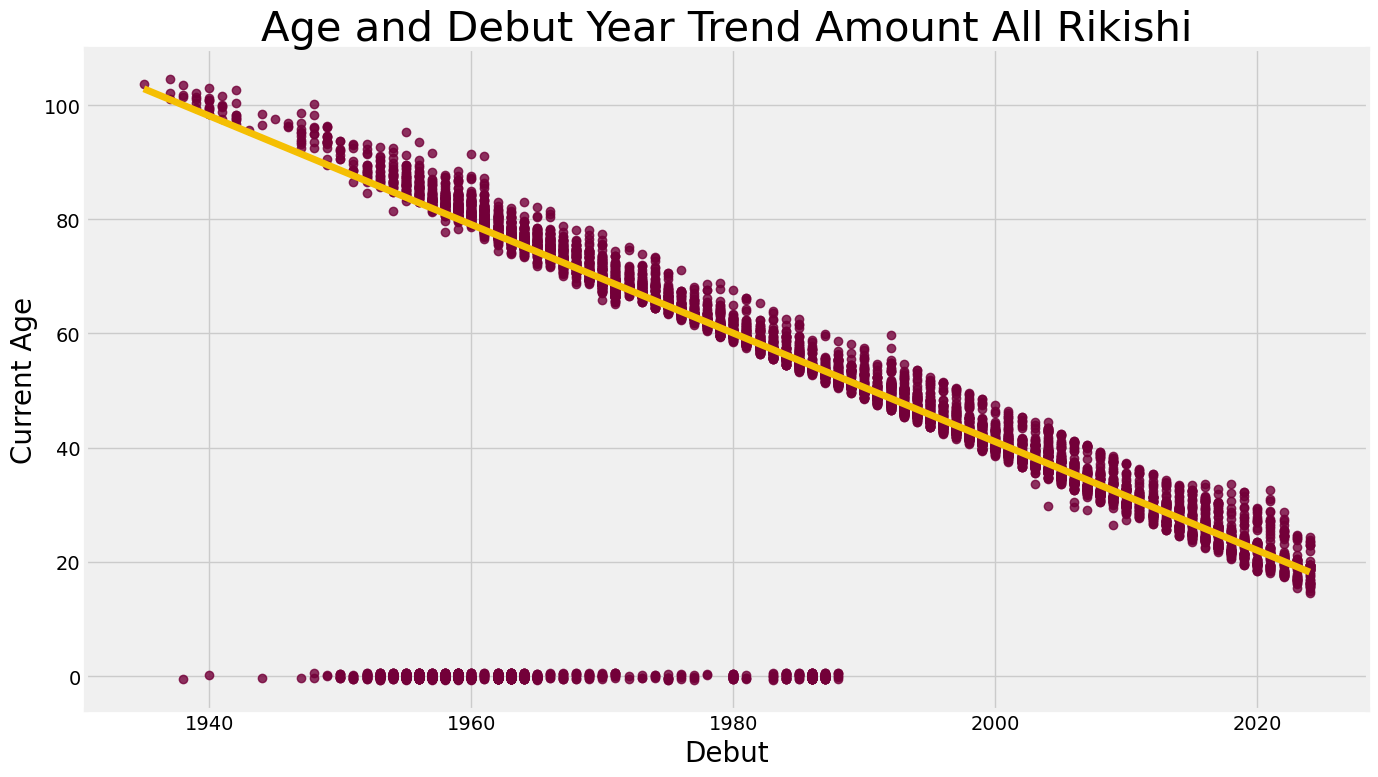

In [125]:
plt.figure(figsize = (14, 8))
plt.style.use('fivethirtyeight')


plt.title('Age and Debut Year Trend Amount All Rikishi',
         size = 30)

plt.xlabel('Debut', size = 20)

sns.regplot(data = sumo_df,
            x = 'debut_year',
            y = 'age',
            ci = None,
            y_jitter = .60,
            scatter_kws={'color':'xkcd:merlot'},
            line_kws={'lw': 5, 'color':'xkcd:golden'},
            robust = True)

plt.xlabel('Debut', size = 20)
plt.ylabel('Current Age', size = 20)

plt.tight_layout()
# plt.savefig('../plots/active_rikisi_age_vs_debut.png', dpi = 192);

#### Make two tables, one where every rikishi has a valid age and one where every rikishi's age equals 0.

In [126]:
age_sumo_df = sumo_df[sumo_df['age'] != 0]
no_age_sumo_df  = sumo_df[sumo_df['age'] == 0].copy()

In [127]:
age_sumo_df.head()

,id,sumodb_id,nsk_id,ring_name,current_rank,height,weight,total_wins,total_losses,total_matches,age,win_rate,debut_year,tenure,ichimon
1,2973,5772,0,Wakahokkai Gentaro,Retired,0.0,0.0,146,160,306,81,47.71,1959,7,Unaffilliated
2,6428,6679,0,Kakuryuasahi,Retired,178.5,111.0,26,23,49,53,53.06,1987,1,Isegahama
3,3683,381,0,Katsumayama Shuichi,Retired,177.0,113.5,223,211,434,46,51.38,1994,11,Nishonoseki
4,6560,7299,0,Otsuru,Retired,186.0,77.0,78,73,151,57,51.66,1983,4,Nishonoseki
5,2954,4235,0,Banryunada Kenzo,Retired,173.0,83.0,162,167,329,87,49.24,1953,12,Dewanoumi


#### I'll model with the age_sumo_df

In [129]:
# X needs to have double brackets around debut so that it remains a dataframe.  A dataframe is a 2D array that will work with Scikit-Learn

X = age_sumo_df[['debut_year']]
y = age_sumo_df['age']

In [130]:
# Train, test, split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 24)

In [131]:
lr = LinearRegression()

In [132]:
lr.fit(X_train, y_train)

LinearRegression()

### Train and test -  R2 score and MSE

In [133]:
print(f'Training R-Squared Score: {lr.score(X_train, y_train)}')
print(f'Testing R-Squred Score: {lr.score(X_test, y_test)}')

Training R-Squared Score: 0.9884139906711619
Testing R-Squred Score: 0.9885906228455991


#### Cross Validation

In [134]:
cross_val_score(lr, X_train, y_train).mean()

0.9884042144713325

#### Linear Regression Evaluation

In [135]:
# Predictions on training data and calculating residuals
y_pred = lr.predict(X_test)
resids = y_test - y_pred

In [136]:
print(f'Mean Squared Error: {metrics.mean_squared_error(y_test, y_pred)}')
print(f'Root Mean Squared Error: {metrics.mean_squared_error(y_test, y_pred, squared = False)}')

Mean Squared Error: 3.985316710474552
Root Mean Squared Error: 1.9963258026871646


### Baseline Model

#### A MSE of 3.99 is a big improvement over 344

In [137]:
y_bar = np.mean(y_test)

In [138]:
print(f'Null Mean Squared Error: {np.mean((y - y_bar)**2)}')
print(f'Null Root Mean Squared Error: {np.sqrt(np.mean((y - y_bar)**2))}')

Null Mean Squared Error: 344.229656467863
Null Root Mean Squared Error: 18.553427081481818


### LINE Assumptions

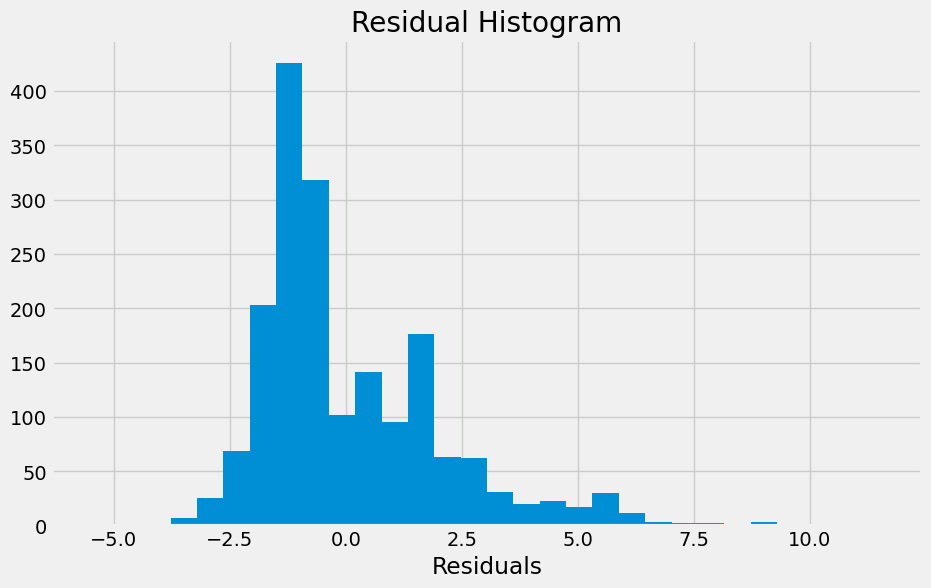

In [139]:
plt.figure(figsize=(10, 6))
plt.hist(resids, bins = 30)
plt.xlabel('Residuals')
plt.title('Residual Histogram');

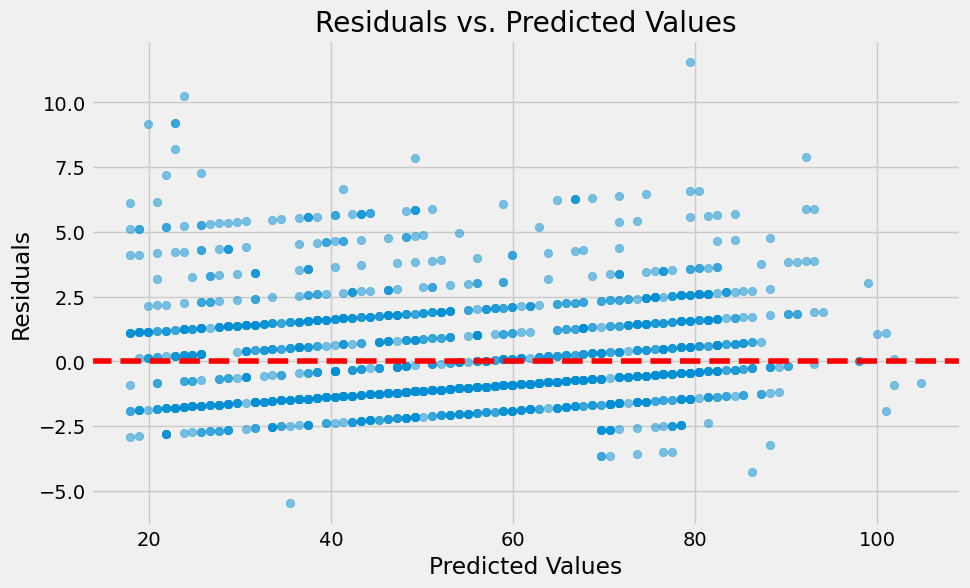

In [140]:
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, resids, alpha=0.5)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values')
plt.axhline(y=0, color='r', linestyle='--')

#### Drop the age column on the no_age_sumo_df and make predictions.

In [141]:
no_age_sumo_df.drop(columns = ['age'], inplace = True)

In [143]:
unseen_age_df = no_age_sumo_df[['debut_year']]

In [144]:
no_age_sumo_df['age_predicted'] = lr.predict(unseen_age_df).astype(int)

#### Merge predicted data in with original sumo_df

In [145]:
# This works because the indexing between the two dataframes remained the same.  The mask is TRUE
# when 'age' is 0.  If true, the value will be updated with the 'age_predicted' value at the same index
# in no_age_sumo_df.

mask = sumo_df['age'] == 0
sumo_df.loc[mask, 'age'] = no_age_sumo_df.loc[mask, 'age_predicted']

In [146]:
no_age_sumo_df

,id,sumodb_id,nsk_id,ring_name,current_rank,height,weight,total_wins,total_losses,total_matches,win_rate,debut_year,tenure,ichimon,age_predicted
0,7522,10438,0,Hakushuzan,Retired,0.0,0.0,27,36,63,42.86,1954,5,Unaffilliated,86
6,7711,10220,0,Odagiri,Retired,0.0,0.0,35,37,72,48.61,1957,2,Unaffilliated,83
12,7702,10835,0,Sachinoumi,Retired,0.0,0.0,7,9,16,43.75,1956,2,Unaffilliated,84
18,8755,11222,0,Yamanomoto,Retired,0.0,0.0,18,14,32,56.25,1959,1,Unaffilliated,81
19,8530,5601,0,Daishinyama#,Retired,0.0,0.0,5,2,7,71.43,1969,1,Unaffilliated,71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8861,7379,6922,0,Takabayama,Retired,0.0,0.0,18,38,56,32.14,1950,9,Unaffilliated,90
8866,7647,10546,0,Takano,Retired,0.0,0.0,41,55,96,42.71,1954,6,Unaffilliated,86
8871,6696,7366,0,Sakura,Retired,0.0,0.0,13,6,19,68.42,1986,1,Isegahama,55
8877,7047,7776,0,Mishima,Retired,0.0,0.0,7,14,21,33.33,1987,0,Dewanoumi,54


In [148]:
debut_count = sumo_df['debut_year'].value_counts().sort_index()
debut_count_df = debut_count.to_frame().reset_index()
debut_count_df.columns = ['year', 'count']

In [149]:
debut_count_df
debut_count_after_1950_df = debut_count_df[debut_count_df['year'] >= 1950]

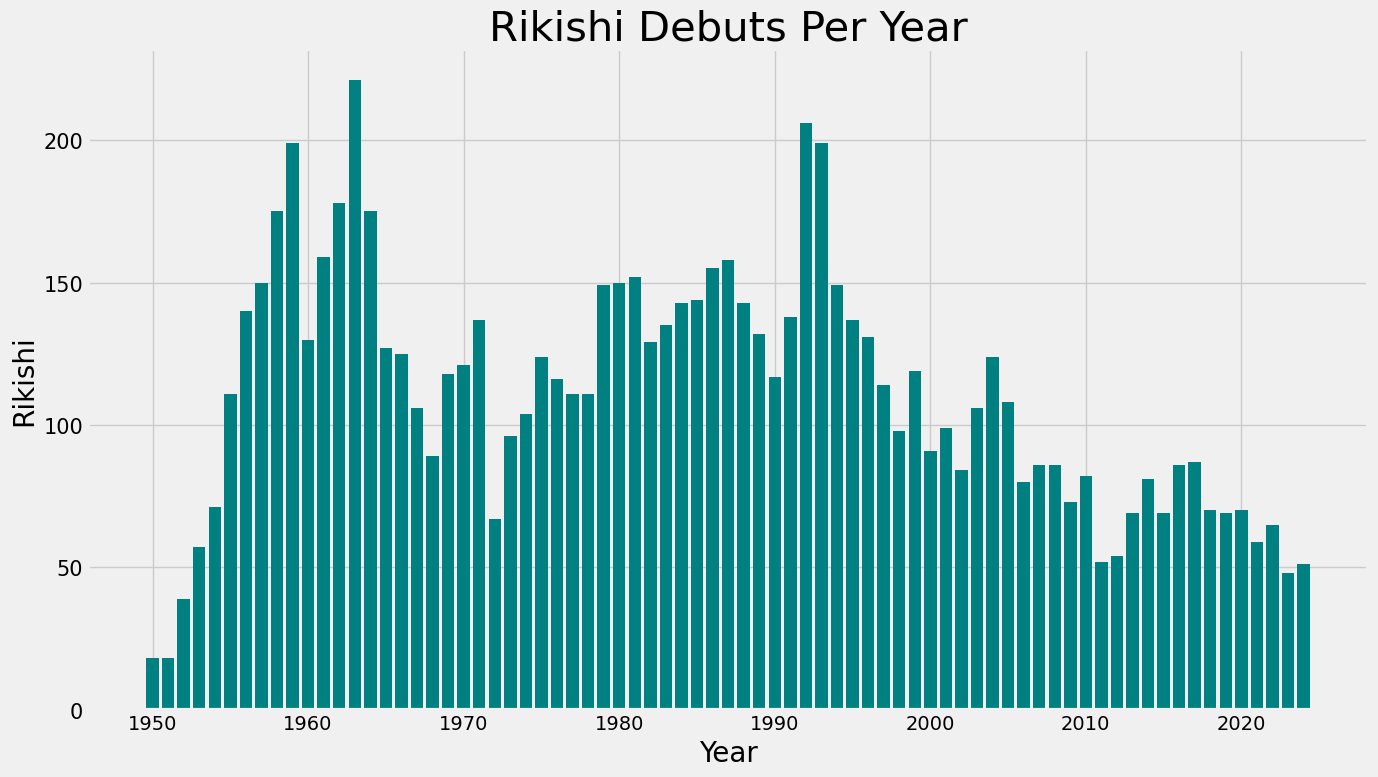

In [150]:
plt.figure(figsize=(14, 8))  # Increase figure size for better readability
plt.style.use('fivethirtyeight')

# Bar Plot
plt.bar(debut_count_after_1950_df['year'], debut_count_after_1950_df['count'], color='teal')

# Customize Titles and Labels
plt.xlabel('Year', size=20)
plt.ylabel('Rikishi', size=20)
plt.title('Rikishi Debuts Per Year', size=30)

# Customize x-ticks

# Customize y-ticks
plt.yticks(size=15)

# Adjust layout to fit labels and titles
plt.tight_layout()

plt.savefig('../plots/sumo_debuts.png', dpi = 192);